In [1]:
import h5py
import numpy as np
import PIL.Image as Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint



In [2]:
import numpy as np
import PIL.Image as Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

def load_h5_to_dictionary(file_path):
    data_dict = {}
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            # Create a list to store the arrays for each key
            array_list = []
            # Get the group corresponding to the current key
            group = hf[key]
            for dataset_name in group.keys():
                # Append each dataset (array) to the array list
                array_list.append(np.array(group[dataset_name]))
            # Store the array list for the current key in the dictionary
            data_dict[key] = array_list
    return data_dict

In [4]:
file_path = 'content/datasets/h5_out/raw_image_sim.h5'
loaded_dictionary_images_sim=load_h5_to_dictionary(file_path)

file_path = 'content/datasets/h5_out/segmentation_masks_list_sim.h5'
loaded_segmentation_masks_sim=load_h5_to_dictionary(file_path)

file_path = 'content/datasets/h5_out/semantic_id_list_sim.h5'
loaded_semantic_id_sim=load_h5_to_dictionary(file_path)

In [ ]:
def find_lowest_dimensions(images_list1, images_list2):
    lowest_height = min(images_list1[0].shape[0], images_list2[0].shape[0])
    lowest_width = min(images_list1[0].shape[1], images_list2[0].shape[1])
    return lowest_height, lowest_width

def crop_images_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width,:] for image in images_list]
    return cropped_images

def crop_1d_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width] for image in images_list]
    return cropped_images

desired_semantic_id = 0
def map_to_r(number):
    colorr = [255, 128, 0, 0, 128, 0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 255, 128, 255, 0, 128]
    if number < 20:
        return int(colorr[number])
    else:
        return 0

def map_to_g(number):
    colorg = [0, 128, 255, 128, 0, 0, 128, 0, 0, 128, 0, 128, 0, 128, 255, 128, 0, 128, 255, 128]
    if number < 20:
        return int(colorg[number])
    else:
        return 0

def map_to_b(number):
    colorb = [0, 0, 0, 128, 128, 255, 255, 128, 0, 128, 128, 255, 128, 0, 0, 0, 128, 255, 255, 128]
    if number < 20:
        return int(colorb[number])
    else:
        return 255


dataset_index_list=["0001","0002","0006","0018","0020"]


lowest_height=10000
lowest_width=10000

for dataset_index in dataset_index_list:
  height, width = find_lowest_dimensions(loaded_dictionary_images_sim[dataset_index], loaded_semantic_id_sim[dataset_index])
  lowest_height=min(height,lowest_height)
  lowest_width=min(width,lowest_width)
print(lowest_height,lowest_width)


for dataset_index in dataset_index_list:
    loaded_dictionary_images_sim[dataset_index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_sim[dataset_index], lowest_height, lowest_width)
    loaded_semantic_id_sim[dataset_index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_sim[dataset_index], lowest_height, lowest_width)
    loaded_segmentation_masks_sim[dataset_index] = crop_images_to_lowest_dimensions(loaded_segmentation_masks_sim[dataset_index], lowest_height, lowest_width)



In [6]:


dataset_index_list_train=["0001","0002","0006"]
dataset_index_list_to_perturb=["0018"]
dataset_index_list_test=["0020"]

In [9]:
train_indexes_sim = {}
validation_indexes_sim = {}
test_indexes_sim = {}

pattern = 'tttttttttv'
pattern_pointer = 0
for dataset_index in dataset_index_list_train:
  train_dataset_indices_inner = []
  test_dataset_indices_inner = []
  for index in range(1, len(loaded_dictionary_images_sim[dataset_index])):
    pattern_char = pattern[pattern_pointer]
    if pattern_char == 't':
        train_dataset_indices_inner.append(index)
    else:
        test_dataset_indices_inner.append(index)
    pattern_pointer = (pattern_pointer + 1) % len(pattern)
  train_indexes_sim[dataset_index]=train_dataset_indices_inner
  validation_indexes_sim[dataset_index]=test_dataset_indices_inner

for dataset_index in dataset_index_list_test:
  test_dataset_inner = []
  for index in range(1, len(loaded_dictionary_images_sim[dataset_index])):
    test_dataset_inner.append(index)
  test_indexes_sim[dataset_index]=test_dataset_inner

In [10]:
print("Segmentation train and validation sim")
for dataset_index in dataset_index_list_train:
    print("Dataset", dataset_index)
    print("Train: ",len(train_indexes_sim[dataset_index]))
    print("Validation: ",len(validation_indexes_sim[dataset_index]))
print("Segmentation test sim") 
for dataset_index in dataset_index_list_test:
    print("Dataset", dataset_index)
    print("Test: ",len(test_indexes_sim[dataset_index]))

Segmentation train and validation sim
Dataset 0001
Train:  402
Validation:  44
Dataset 0002
Train:  209
Validation:  23
Dataset 0006
Train:  242
Validation:  27
Segmentation test sim
Dataset 0020
Test:  836


In [11]:
import tensorflow as tf
import numpy as np

def map_to_desired_structure(input_image, output_image):
    return {'pixel_values': input_image, 'labels': output_image}

def map_values(value):
    # if value in [1, 2, 6, 7, 8, 16, 21, 255]:
    #     return 1
    # elif value in [11, 12]:
    #     return 2
    # elif value in [13, 14, 15, 17]:
    #     return 3
    # elif value == 10:
    #     return 4
    # elif value == 0:
    #     return 0
    # else:
    #     return 1
    # if value==255:
    #     value= 22
    return value

def generator(input_dict, output_dict, input_indices, input_dic_keys):
    vectorized_map = np.vectorize(map_values)
    for key in input_dic_keys:
        for index in input_indices[key]:
            if index < len(input_dict[key]):
                input_image = input_dict[key][index]
                output_image = output_dict[key][index]
                
                input_image = tf.reverse(input_image, axis=[-1])
                input_image = tf.transpose(input_image, (2, 0, 1))
                output_image = vectorized_map(output_image)
                yield input_image, output_image

def create_tf_dataset(input_dict, output_dict, input_indices, input_dic_keys, batch_size=5):
    # Use a generator to load the data lazily
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(input_dict, output_dict, input_indices, input_dic_keys),
        output_signature=(
            tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),  # Input image shape
            tf.TensorSpec(shape=(None, None), dtype=tf.float32)          # Output image shape
        )
    )
    dataset = dataset.map(map_to_desired_structure)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
tf_dataset_train_sim = create_tf_dataset(loaded_dictionary_images_sim, loaded_semantic_id_sim, train_indexes_sim,dataset_index_list_train)
tf_dataset_validation_sim = create_tf_dataset(loaded_dictionary_images_sim, loaded_semantic_id_sim, validation_indexes_sim,dataset_index_list_train)
tf_dataset_test_sim = create_tf_dataset(loaded_dictionary_images_sim, loaded_semantic_id_sim, test_indexes_sim,dataset_index_list_test)

In [13]:
train_dataset =tf_dataset_train_sim
valid_dataset=tf_dataset_validation_sim
test_dataset =tf_dataset_test_sim

In [14]:
auto = tf.data.AUTOTUNE

train_ds = (
    train_dataset
    .prefetch(auto)
)

valid_ds = (
    valid_dataset
    .prefetch(auto)
)

test_ds = (
    test_dataset
    .prefetch(auto)
)

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask","diff"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        img=tf.keras.utils.array_to_img(display_list[i])
        img_raw=display_list[i].numpy().astype(int)[:,:,0]
        if i>0:
            print(np.unique(img_raw))
            colored_mask = np.zeros_like(tf.keras.utils.array_to_img(display_list[0]))
            colored_mask[:, :, 0] = np.vectorize(map_to_b)(img_raw)
            colored_mask[:, :, 1] = np.vectorize(map_to_g)(img_raw)
            colored_mask[:, :, 2] = np.vectorize(map_to_r)(img_raw)
            img=colored_mask
        plt.imshow(img)
        plt.axis("off")
    plt.show()

Sim segm train


2024-09-18 22:31:18.479079: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[ 0  1  2  7  8 10 13 14]


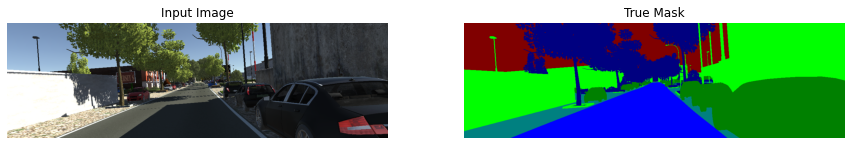

[ 0  1  2  7  8 10 13 14]


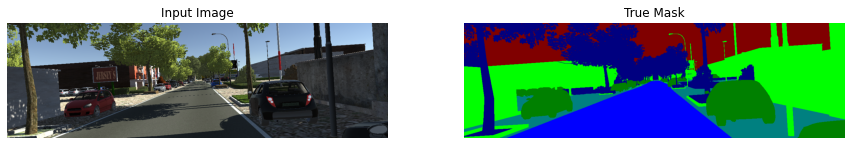

[ 0  1  2  7  8 10 13 14]


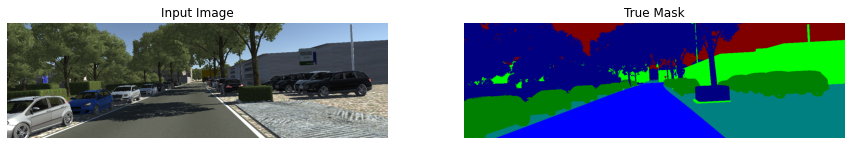

[ 0  1  2  7  8 10 13 14]


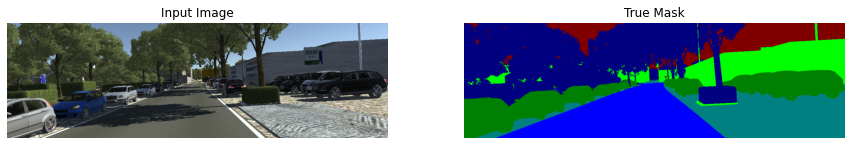

[ 0  1  2  7  8 10 13 14]


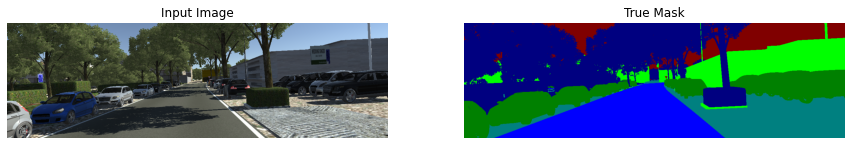

In [16]:
print("Sim segm train")
i=0
for samples in train_ds.take(1):
    for i in range(0,5):
        sample_image, sample_mask = samples["pixel_values"][i], samples["labels"][i]
        sample_image = tf.transpose(sample_image, (1, 2, 0))
        
        sample_mask = tf.expand_dims(sample_mask, -1)
        display([sample_image, sample_mask])

sim valid
[ 0  1  2  7  8 10 13 14]


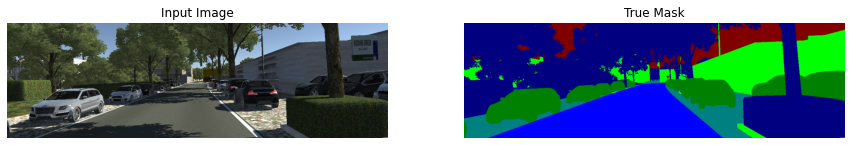

[ 0  1  2  7  8 10 13 14]


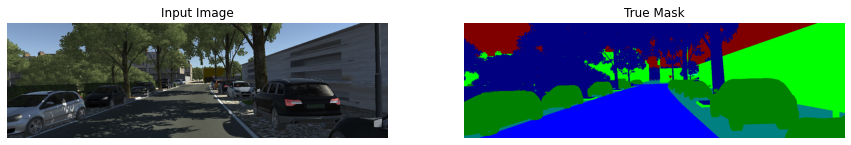

[ 0  1  2  7  8 10 13 14]


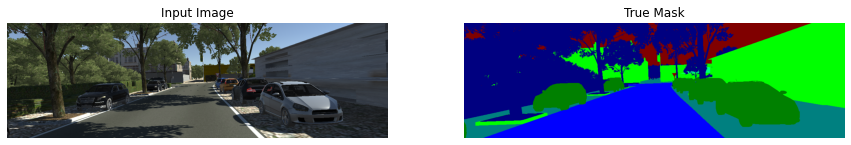

[ 0  1  2  7  8 10 13 14]


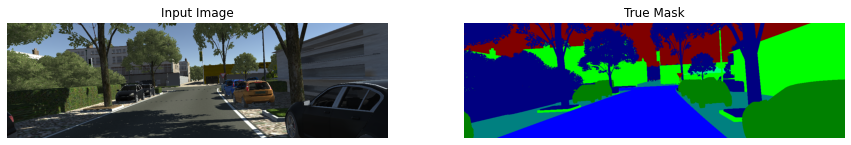

[ 0  1  2  7  8 10 13 14]


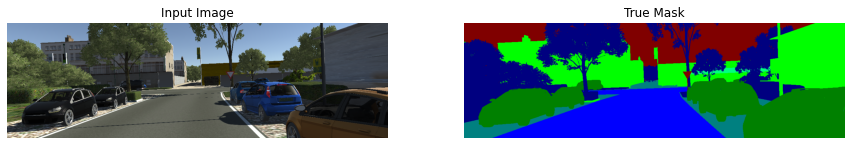

In [17]:


print("sim valid")
for samples in valid_ds.take(1):
    for i in range(0,5):
        sample_image, sample_mask = samples["pixel_values"][i], samples["labels"][i]
        sample_image = tf.transpose(sample_image, (1, 2, 0))
        
        sample_mask = tf.expand_dims(sample_mask, -1)
        display([sample_image, sample_mask])



sim test
(5, 374, 1238)
[ 0  1  2  7  8 10 13 21]


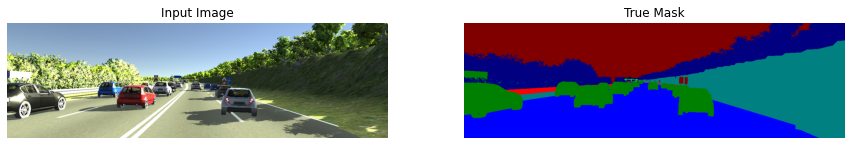

[ 0  1  2  7  8 10 13 21]


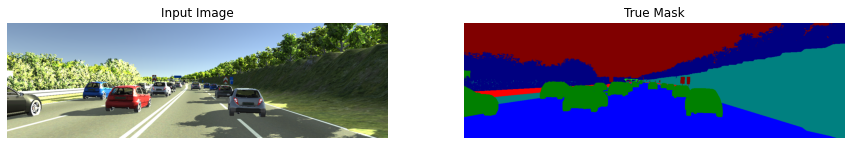

[ 0  1  2  7  8 10 13 21]


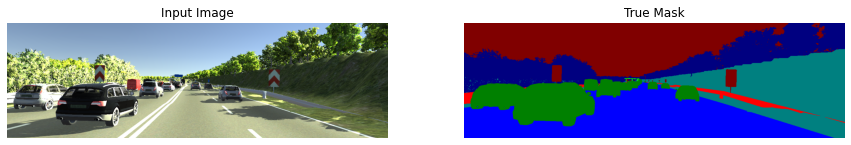

[ 0  1  2  7  8 10 13 21]


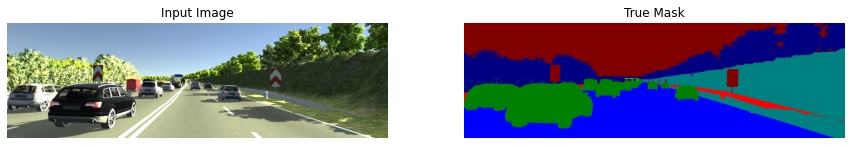

[ 0  1  2  7  8 10 13 21]


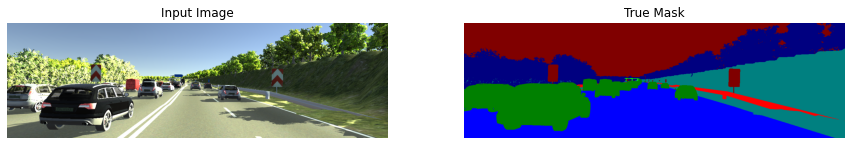

In [18]:
print("sim test")
for samples in test_ds.take(1):
    print(samples["labels"].shape)
    for i in range(0,5):
        sample_image, sample_mask = samples["pixel_values"][i], samples["labels"][i]
        sample_image = tf.transpose(sample_image, (1, 2, 0))
        
        sample_mask = tf.expand_dims(sample_mask, -1)
        display([sample_image, sample_mask])

In [ ]:
from transformers import  TFSegformerForSemanticSegmentation,SegformerFeatureExtractor
from PIL import Image
import requests

model_checkpoint = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"

# id2label mapping for the KITTI dataset
label2id = {
        'Road': 0,
        'Sidewalk': 1,
        'Building': 2,
        'Wall': 3,
        'Fence': 4,
        'Pole': 5,
        'TrafficLight': 6,
        'TrafficSign': 7,
        'Vegetation': 8,
        'Terrain': 9,
        'Sky': 10,
        'Person': 11,
        'Rider': 12,
        'Car': 13,
        'Truck': 14,
        'Bus': 15,
        'Train': 16,
        'Motorcycle': 17,
        'Bicycle': 18,
        'Void': 255,
        'Misc': 19,
        'GuardRail': 20,
    }
id2label = {label: id for id, label in label2id.items()}
num_labels = len(id2label)
print(len(id2label))
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)



In [22]:
from IPython.display import clear_output

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]
    
def cast_to_int32(image):
    # Normalize the image pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert to uint8 by scaling the values back to [0, 255]
    image = tf.cast(image * 255, tf.int32)
    return image
    
desired_semantic_id=0
def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            
            images, masks = sample["pixel_values"], sample["labels"]
            
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            created_mask=cast_to_int32(create_mask(pred_masks))
            created_mask = tf.image.resize(created_mask, [374, 1238],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            gt=cast_to_int32(masks[0])
            diff_mask_road=abs(created_mask-gt)
            display([images[0], gt,created_mask,diff_mask_road ])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [23]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

[ 0  1  2  7  8 10 13 21]
[ 0  1  2  7  8 10 13 14]
[ 0  1  2  3  5  6  7  8 11 12 13 20 21]


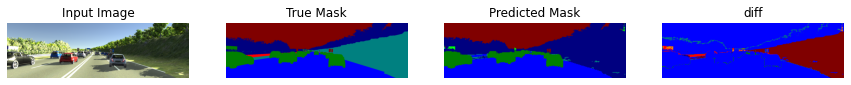


Sample Prediction after epoch 10


Epoch 10: val_loss improved from 0.09453 to 0.09025, saving model to ./content/Model_original.hdf5
171/171 [==============================] - 199s 1s/step - loss: 0.0896 - val_loss: 0.0902


In [25]:
CheckpointCallback = ModelCheckpoint("./content/Model_original.hdf5", verbose=1, monitor='val_loss', save_best_only=True,save_weights_only=True)
epochs = 10
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    callbacks=[DisplayCallback(test_ds), CheckpointCallback],
    epochs=epochs,
)
    

[ 0  1  2  7  8 10 13 21]
[ 0  1  2  7  8 10 13 14]
[ 0  1  2  3  5  6  7  8 11 12 13 20 21]


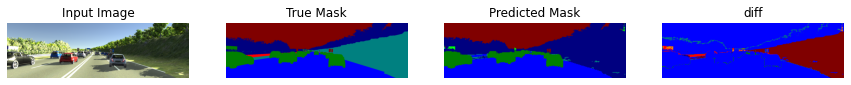

In [26]:
show_predictions(test_ds)

In [27]:
checkpoint_file_path = "./content/Model_original.hdf5"
model.save_weights(checkpoint_file_path)